# Pakistan COVID19 Prediction
## Data From [Kaggle covid19 global forcasting week3](https://www.kaggle.com/c/covid19-global-forecasting-week-3)

In [34]:
# IMPORTS
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

In [2]:
%%time
# LOAD TRAIN DATA
train_old = pd.read_csv('train-04Mar2020.csv')
train_new = pd.read_csv('train-05Mar2020.csv')

Wall time: 72.1 ms


In [4]:
#Old train data correction
df = train_old[train_old['Country_Region']=='Pakistan']
Pakistan_data_old = df.copy()
Pakistan_data_old= Pakistan_data_old[Pakistan_data_old.ConfirmedCases > 0.0]
Pakistan_data_old.reset_index(inplace=True)
Pakistan_data_old.drop(columns= ['index','Id','Province_State'],inplace=True)
Pakistan_data_old['ConfirmedCases'] = Pakistan_data_old['ConfirmedCases'].astype(int) 
Pakistan_data_old['Fatalities'] = Pakistan_data_old['Fatalities'].astype(int) 
Pakistan_data_old.head()

,Country_Region,Date,ConfirmedCases,Fatalities
0,Pakistan,2020-02-26,2,0
1,Pakistan,2020-02-27,2,0
2,Pakistan,2020-02-28,2,0
3,Pakistan,2020-02-29,4,0
4,Pakistan,2020-03-01,4,0


In [5]:
#New train data correction
df = train_new[train_new['Country_Region']=='Pakistan']
Pakistan_data_new = df.copy()
Pakistan_data_new= Pakistan_data_new[Pakistan_data_new.ConfirmedCases > 0.0]
Pakistan_data_new.reset_index(inplace=True)
Pakistan_data_new.drop(columns= ['index','Id','Province_State'],inplace=True)
Pakistan_data_new['ConfirmedCases'] = Pakistan_data_new['ConfirmedCases'].astype(int) 
Pakistan_data_new['Fatalities'] = Pakistan_data_new['Fatalities'].astype(int) 
Pakistan_data_new.head()

,Country_Region,Date,ConfirmedCases,Fatalities
0,Pakistan,2020-02-26,2,0
1,Pakistan,2020-02-27,2,0
2,Pakistan,2020-02-28,2,0
3,Pakistan,2020-02-29,4,0
4,Pakistan,2020-03-01,4,0


In [6]:
#old data month adjust
month_day_list = []
for date in Pakistan_data_old['Date']:
    month_day_list.append(date.split('2020-0')[1])

Pakistan_data_old['Month_Day'] = month_day_list
Pakistan_data_old.head()

,Country_Region,Date,ConfirmedCases,Fatalities,Month_Day
0,Pakistan,2020-02-26,2,0,2-26
1,Pakistan,2020-02-27,2,0,2-27
2,Pakistan,2020-02-28,2,0,2-28
3,Pakistan,2020-02-29,4,0,2-29
4,Pakistan,2020-03-01,4,0,3-01


In [7]:
#new data month adjust
month_day_list = []
for date in Pakistan_data_new['Date']:
    month_day_list.append(date.split('2020-0')[1])

Pakistan_data_new['Month_Day'] = month_day_list
Pakistan_data_new.head()

,Country_Region,Date,ConfirmedCases,Fatalities,Month_Day
0,Pakistan,2020-02-26,2,0,2-26
1,Pakistan,2020-02-27,2,0,2-27
2,Pakistan,2020-02-28,2,0,2-28
3,Pakistan,2020-02-29,4,0,2-29
4,Pakistan,2020-03-01,4,0,3-01


In [8]:
def Calculate_Table ( X_train ):
    # CALCULATE EXPANSION TABLE
    diff_conf, conf_old = [], 0 
    diff_fat, fat_old = [], 0
    dd_conf, dc_old = [], 0
    dd_fat, df_old = [], 0
    ratios = []
    for row in X_train.values:
        diff_conf.append(row[2]-conf_old)
        conf_old = row[2]
        diff_fat.append(row[3]-fat_old)
        fat_old = row[3]
        dd_conf.append(diff_conf[-1]-dc_old)
        dc_old = diff_conf[-1]
        dd_fat.append(diff_fat[-1]-df_old)
        df_old = diff_fat[-1]
        ratios.append(fat_old / conf_old)
        ratio = fat_old / conf_old
        

    return diff_conf, conf_old, diff_fat, fat_old, dd_conf, dc_old, dd_fat, df_old, ratios, ratio

In [9]:
def populate_df_features(X_train,diff_conf, diff_fat, dd_conf, dd_fat, ratios):    
    # POPULATE DATAFRAME FEATURES
    pd.options.mode.chained_assignment = None  # default='warn'
    X_train['diff_confirmed'] = diff_conf
    X_train['diff_fatalities'] = diff_fat
    X_train['dd_confirmed'] = dd_conf
    X_train['dd_fatalities'] = dd_fat
    X_train['ratios'] = ratios
    return X_train

In [10]:
def fill_nan ( variable):
    if math.isnan(variable):
        return 0
    else:
        return variable

In [11]:
def Cal_Series_Avg(X_train,ratio):
    # CALCULATE SERIES AVERAGES
    d_c = fill_nan( X_train.diff_confirmed[X_train.diff_confirmed != 0].mean() )
    dd_c = fill_nan( X_train.dd_confirmed[X_train.dd_confirmed != 0].mean() )
    d_f = fill_nan( X_train.diff_fatalities[X_train.diff_fatalities != 0].mean() )
    dd_f = fill_nan( X_train.dd_fatalities[X_train.dd_fatalities != 0].mean() )
    rate = fill_nan( X_train.ratios[X_train.ratios != 0].mean() )
    #print("rate: %.2f ratio: %.2f" %(rate,ratio))
    #print("d_c: %.2f, dd_c: %.2f, d_f: %.2f, dd_f: %.2f "%(d_c, dd_c, d_f, dd_f))
    rate = max(rate,ratio)
    return d_c, dd_c, d_f, dd_f, rate

In [12]:
def apply_taylor(train, d_c, dd_c, d_f, dd_f, rate):
    # ITERATE TAYLOR SERIES
    
    pred_c, pred_f = [],[]
    for i in range(1, 34):
        pred_c.append(int( ( train.ConfirmedCases[len(train)-1] + d_c*i + 0.5*dd_c*(i**2)) ) )
        pred_f.append(pred_c[-1]*rate )
    return pred_c, pred_f

In [16]:
# for old data
diff_conf, conf_old, diff_fat, fat_old, dd_conf, dc_old, dd_fat, df_old, ratios, ratio = Calculate_Table(Pakistan_data_old)

Pakistan_data_old = populate_df_features(Pakistan_data_old,diff_conf, diff_fat, dd_conf, dd_fat, ratios)

d_c, dd_c, d_f, dd_f, rate = Cal_Series_Avg(Pakistan_data_old, ratio)

pc_old, pf_old = apply_taylor(Pakistan_data_old, d_c, dd_c, d_f, dd_f, rate)

In [17]:
# for new data
diff_conf, conf_old, diff_fat, fat_old, dd_conf, dc_old, dd_fat, df_old, ratios, ratio = Calculate_Table(Pakistan_data_new)

Pakistan_data_new = populate_df_features(Pakistan_data_new,diff_conf, diff_fat, dd_conf, dd_fat, ratios)

d_c, dd_c, d_f, dd_f, rate = Cal_Series_Avg(Pakistan_data_new, ratio)

pc_new, pf_new = apply_taylor(Pakistan_data_new, d_c, dd_c, d_f, dd_f, rate)

In [18]:
len(pc_old), len(pf_old), len(pc_new), len(pf_new)

(33, 33, 33, 33)

In [19]:
Pakistan_data_new.iloc[:,:]

,Country_Region,Date,ConfirmedCases,Fatalities,Month_Day,diff_confirmed,diff_fatalities,dd_confirmed,dd_fatalities,ratios
0,Pakistan,2020-02-26,2,0,2-26,2,0,2,0,0.000000
1,Pakistan,2020-02-27,2,0,2-27,0,0,-2,0,0.000000
2,Pakistan,2020-02-28,2,0,2-28,0,0,0,0,0.000000
3,Pakistan,2020-02-29,4,0,2-29,2,0,2,0,0.000000
4,Pakistan,2020-03-01,4,0,3-01,0,0,-2,0,0.000000
5,Pakistan,2020-03-02,4,0,3-02,0,0,0,0,0.000000
6,Pakistan,2020-03-03,5,0,3-03,1,0,1,0,0.000000
7,Pakistan,2020-03-04,5,0,3-04,0,0,-1,0,0.000000
8,Pakistan,2020-03-05,5,0,3-05,0,0,0,0,0.000000
9,Pakistan,2020-03-06,6,0,3-06,1,0,1,0,0.000000


In [20]:
Pakistan_data_old.shape, Pakistan_data_new.shape

((39, 10), (40, 10))

In [21]:
dates = pd.read_csv('test (1).csv')
dates.drop(columns= ['ForecastId','Province_State','Country_Region'],inplace=True)
dates = dates.iloc[10:43,:]

pd_list = []
for date in dates.Date:
    pd_list.append(date.split('2020-0')[1])

Date_list = list(Pakistan_data_new.Month_Day.copy())
Date_list.extend(pd_list)
#Date_list

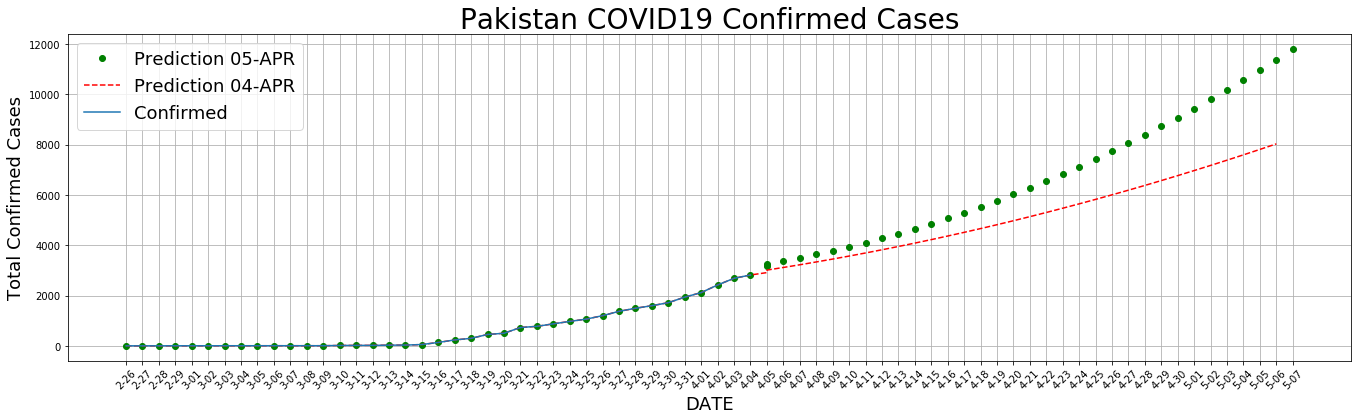

In [37]:
plt.figure(figsize=(23,6))

tpc = list(Pakistan_data_old.ConfirmedCases.copy())
tpc.extend(pc_old)
tpc2 = list(Pakistan_data_new.ConfirmedCases.copy())
tpc2.extend(pc_new)
plt.plot(Date_list,tpc2,'go',label='Prediction 05-APR')
plt.plot(Date_list[:-1],tpc,'r',linestyle='dashed',label='Prediction 04-APR')

plt.plot(Pakistan_data_old.ConfirmedCases,label='Confirmed')
plt.xlabel("DATE",fontdict={'fontsize': 18})
plt.ylabel("Total Confirmed Cases",fontdict={'fontsize': 18})
plt.legend(fontsize= 18)
plt.title('Pakistan COVID19 Confirmed Cases',fontdict={'fontsize': 28})
plt.xticks(rotation = 45)
plt.grid()
#plt.yscale('log')
#plt.xscale('log')
plt.show()


In [41]:
model_old = SARIMAX(Pakistan_data_old.ConfirmedCases, order=(1, 0, 0), trend='t')
model_old_fit = model_old.fit()

model_new = SARIMAX(Pakistan_data_new.ConfirmedCases, order=(1, 0, 0), trend='t')
model_new_fit = model_new.fit()

# make prediction
start_old = len(Pakistan_data_old.ConfirmedCases)
data_old = Pakistan_data_old.ConfirmedCases
yh_old = model_old_fit.predict(start_old,71)
pccs_old= list(data_old[0:start_old])
pccs_old.extend(list(yh_old))

start_new = len(Pakistan_data_new.ConfirmedCases)
data_new = Pakistan_data_new.ConfirmedCases
yh_new = model_new_fit.predict(start_new,72)
pccs_new= list(data_new[0:start_new])
pccs_new.extend(list(yh_new))


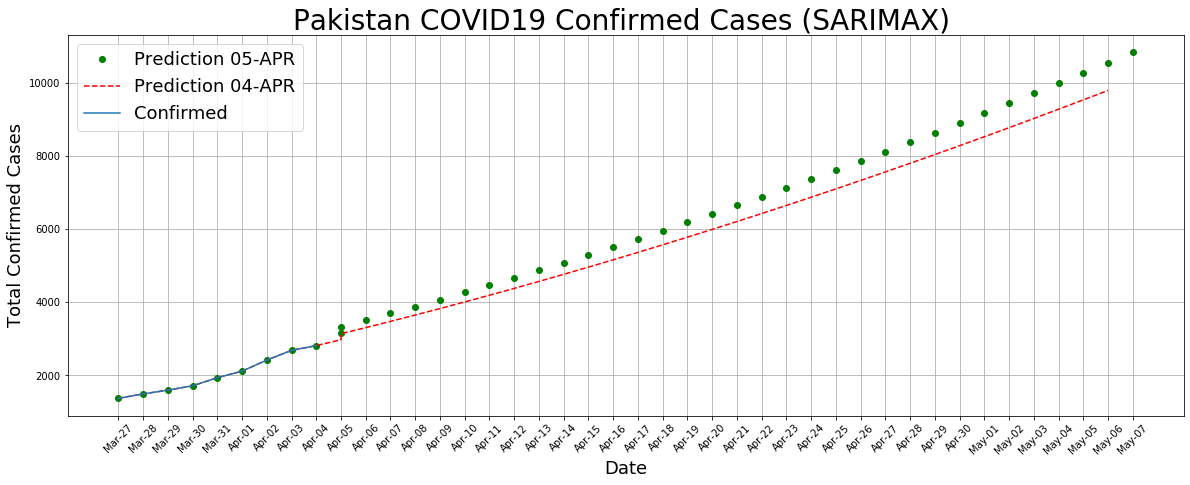

In [44]:
pccso = pccs_old[30:]
pccsn = pccs_new[30:]
dls = Date_list[30:]
for i,d in enumerate(dls):
    dls[i] = d.replace("3-","Mar-")
    dls[i] = dls[i].replace("4-","Apr-")
    dls[i] = dls[i].replace("5-","May-")
ccs = Pakistan_data_old.ConfirmedCases[30:]
plt.figure(figsize=(20,7))
plt.plot(dls,pccsn,'go',label='Prediction 05-APR')
plt.plot(dls[:-1],pccso,'r',linestyle='dashed',label='Prediction 04-APR')
plt.plot(dls[:9],ccs,label='Confirmed')
plt.xlabel("Date",fontdict={'fontsize': 18})
plt.ylabel("Total Confirmed Cases",fontdict={'fontsize': 18})
plt.legend(fontsize= 18)
plt.title('Pakistan COVID19 Confirmed Cases (SARIMAX) ',fontdict={'fontsize': 28})
plt.xticks(rotation=45)
plt.grid()
plt.show()

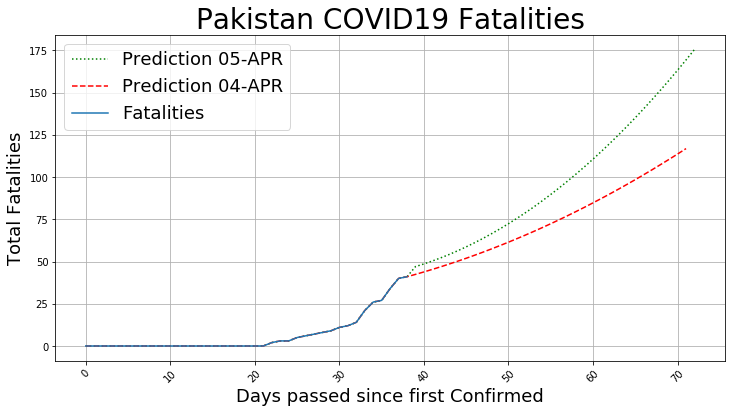

In [47]:
plt.figure(figsize=(12,6))

tpfo = list(Pakistan_data_old.Fatalities.copy())
tpfo.extend(pf_old)
tpfn = list(Pakistan_data_new.Fatalities.copy())
tpfn.extend(pf_new)
plt.plot(tpfn,'g:',label='Prediction 05-APR')
plt.plot(tpfo,'r',linestyle='dashed',label='Prediction 04-APR')
plt.plot(Pakistan_data_old.Fatalities,label='Fatalities')
plt.xlabel("Days passed since first Confirmed",fontdict={'fontsize': 18})
plt.ylabel("Total Fatalities",fontdict={'fontsize': 18})
plt.legend(fontsize= 18)
plt.title('Pakistan COVID19 Fatalities',fontdict={'fontsize': 28})
plt.xticks(rotation=45)
plt.grid()
plt.show()
